In [68]:
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
from string import ascii_letters
import pandas as pd
import seaborn as sns
import matplotlib
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from redTools import *
from Kcorrect import *

In [69]:
inFile  = 'ESN_HI_catal.csv'
band1 = 'r'
band2 = 'w2'

table = getTable(inFile, band1=band1, band2=band2, faceOn=False)

pgc = table['pgc']
logWimx = table['logWimx']
logWimx_e = table['logWimx_e']
inc = table['inc']
r_w1 = table['r_w1']
c21w = table['c21w'] 
Er_w1 = table['Er_w1']
Ec21w = table['Ec21w']

C82  = table['C82_w2']   # concentration 80%/20%
mu50 = table['w2']+2.5*np.log10(2.*np.pi*(table['R50_w2']*60)**2)-2.5*np.log10(table['Wba'])

redTools.py:24: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)


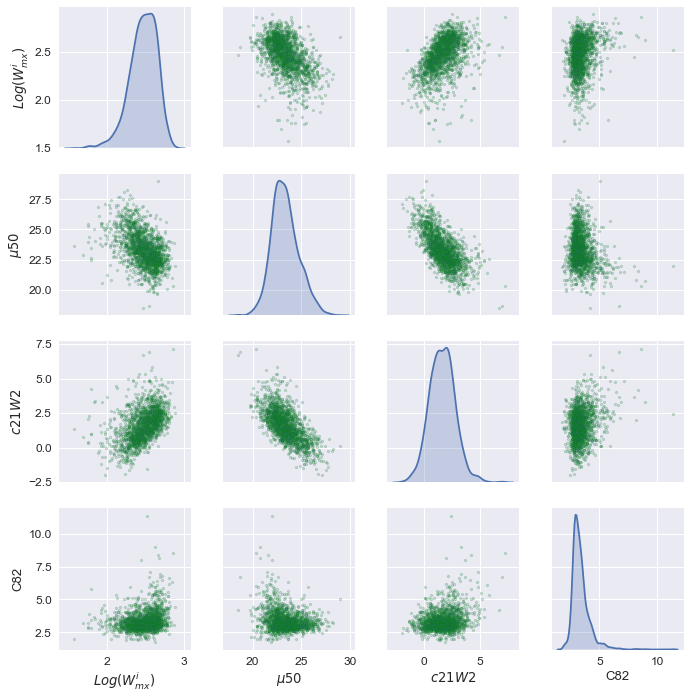

In [70]:
matplotlib.rc('axes',edgecolor='k')

data = {'$Log( W_{mx}^i)$':logWimx, '$c21W2$':c21w, '$\mu 50$':mu50, 'C82': C82}
d = pd.DataFrame.from_dict(data)

sns.set(font_scale=1.2)

pp = sns.pairplot(d, diag_kind="kde", markers=".",
                  plot_kws=dict(s=20, edgecolor="g", alpha=0.2, linewidth=1),diag_kws=dict(shade=True))


In [71]:
z_scaler = StandardScaler()

data = {'$Log( W_{mx}^i)$':logWimx, '$c21W2$':c21w, '$\mu 50$':mu50}
n_comp = len(data)
d = pd.DataFrame.from_dict(data)
z_data = z_scaler.fit_transform(d)

print(z_scaler.mean_)
print(np.sqrt(z_scaler.var_))
print(z_scaler.scale_, z_scaler.mean_, z_scaler.var_)
## z = (x-u)/s
##u: mean  s:scale  var=s**2

pca_trafo = PCA().fit(z_data)
pca_data = pca_trafo.fit_transform(z_data)
A = pca_trafo.explained_variance_ratio_                    # The importance of different PCAs components
pca_inv_data = pca_trafo.inverse_transform(np.eye(n_comp)) # coefficients to make PCs from features

print "PCA variance ratios: ", A
print "Coefficients to make PCAs: ", pca_inv_data

delta = pca_data[:,0]-(pca_inv_data[0,0]*z_data[:,0]+pca_inv_data[0,1]*z_data[:,1]+pca_inv_data[0,2]*z_data[:,2])
print np.sum(delta)

[ 2.46927316 23.34782012  1.62712496]
[0.17962143 1.38279317 1.1468089 ]
(array([0.17962143, 1.38279317, 1.1468089 ]), array([ 2.46927316, 23.34782012,  1.62712496]), array([0.03226386, 1.91211694, 1.31517065]))
PCA variance ratios:  [0.69664861 0.19555218 0.10779921]
Coefficients to make PCAs:  [[ 0.5244107  -0.60326038  0.60089128]
 [-0.85130709 -0.35786403  0.38367899]
 [ 0.01642096  0.71274837  0.70122757]]
3.3953885709980813e-12


In [72]:
table = getTable(inFile, band1=band1, band2=band2, faceOn=True)
pgc = table['pgc']
logWimx = table['logWimx']
logWimx_e = table['logWimx_e']
inc = table['inc']
r_w1 = table['r_w1']
c21w = table['c21w'] 
Er_w1 = table['Er_w1']
Ec21w = table['Ec21w']

C82  = table['C82_w2']   # concentration 80%/20%
mu50 = table['w2']+2.5*np.log10(2.*np.pi*(table['R50_w2']*60)**2)-2.5*np.log10(table['Wba'])

print len(logWimx)
data = {'$Log( W_{mx}^i)$':logWimx, '$c21W2$':c21w, '$\mu 50$':mu50}
d = pd.DataFrame.from_dict(data)
z_data = z_scaler.transform(d)
pca_data = pca_trafo.transform(z_data)

redTools.py:24: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)


167


Text(0,0.5,'$PC0$')

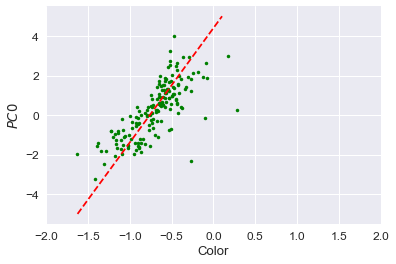

In [73]:
pc0 = pca_data[:,0]
pc1 = pca_data[:,1]
pc2 = pca_data[:,2]

############################################# Geting rid of outliers
a0, b0  = np.polyfit(pc0, r_w1, 1)
delta = np.abs(r_w1-(a0*pc0+b0))
indx = np.where(delta<0.5)
r_w1_ = r_w1[indx]
pc0_ = pc0[indx]
pc1_ = pc1[indx]
pc2_ = pc2[indx]
#############################################

plt.plot(r_w1,pc0, 'g.')
a0, b0  = np.polyfit(pc0_, r_w1_, 1)
y = np.linspace(-5,5,50)
x = a0*y+b0
plt.plot(x,y, 'r--')
plt.xlim([-2,2])

plt.xlabel('Color')
plt.ylabel('$PC0$')

0.16290395397281604
0.16191455120520518


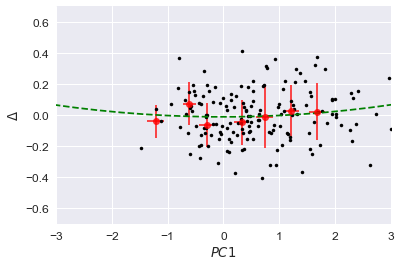

In [74]:
delta = r_w1_-(a0*pc0_+b0)
pc = pc1_

rms = np.sqrt(np.mean(np.square(delta)))
print(rms)   # 0.157   --> 0.175 if we add C82


plt.plot(pc, delta, 'k.')
a, b, c  = np.polyfit(pc, delta, 2)
x = np.linspace(-10,10,50)
y = a*x**2+b*x+c
plt.plot(x,y, 'g--')
plt.xlim([-3,3])
plt.ylim([-0.7,0.7])

plt.xlabel('$PC1$')
plt.ylabel('$\Delta$') 

for i in np.arange(-2,2,0.5):
    
    x = []
    y = []
    for ii in range(len(pc)):
        xi = pc[ii]
        if xi>=i and xi<i+0.5:
            x.append(xi)
            y.append(delta[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

rms = np.sqrt(np.mean(np.square(delta-(a*pc**2+b*pc+c))))
print(rms)


0.15674164206104427


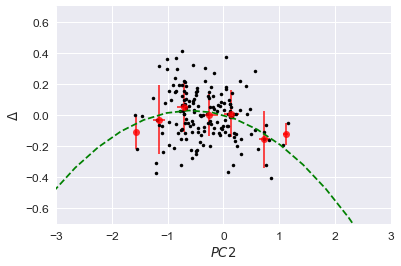

In [75]:
delta = r_w1_-(a0*pc0_+b0)
pc = pc2_

plt.plot(pc, delta, 'k.')
a, b, c  = np.polyfit(pc, delta, 2)
x = np.linspace(-10,10,50)
y = a*x**2+b*x+c
plt.plot(x,y, 'g--')
plt.xlim([-3,3])
plt.ylim([-0.7,0.7])

plt.xlabel('$PC2$')
plt.ylabel('$\Delta$')

for i in np.arange(-3,3,0.5):
    
    x = []
    y = []
    for ii in range(len(pc)):
        xi = pc[ii]
        if xi>=i and xi<i+0.5:
            x.append(xi)
            y.append(delta[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

rms = np.sqrt(np.mean(np.square(delta-(a*pc**2+b*pc+c))))
print(rms)

In [76]:
data = {'r-w1':r_w1, '$Log( W_{mx}^i)$':logWimx, '$c21W2$':c21w, '$\mu 50$':mu50, 'C82':C82}
d = pd.DataFrame.from_dict(data)
print d.corr()
print d.corr().axes
print d.corr()[u'$Log( W_{mx}^i)$'][u'$\mu 50$']

                  $Log( W_{mx}^i)$  $\mu 50$   $c21W2$       C82      r-w1
$Log( W_{mx}^i)$          1.000000 -0.377123  0.276995  0.292048  0.441870
$\mu 50$                 -0.377123  1.000000 -0.665393 -0.359363 -0.733538
$c21W2$                   0.276995 -0.665393  1.000000  0.392835  0.646836
C82                       0.292048 -0.359363  0.392835  1.000000  0.269327
r-w1                      0.441870 -0.733538  0.646836  0.269327  1.000000
[Index([u'$Log( W_{mx}^i)$', u'$\mu 50$', u'$c21W2$', u'C82', u'r-w1'], dtype='object'), Index([u'$Log( W_{mx}^i)$', u'$\mu 50$', u'$c21W2$', u'C82', u'r-w1'], dtype='object')]
-0.37712337175609933


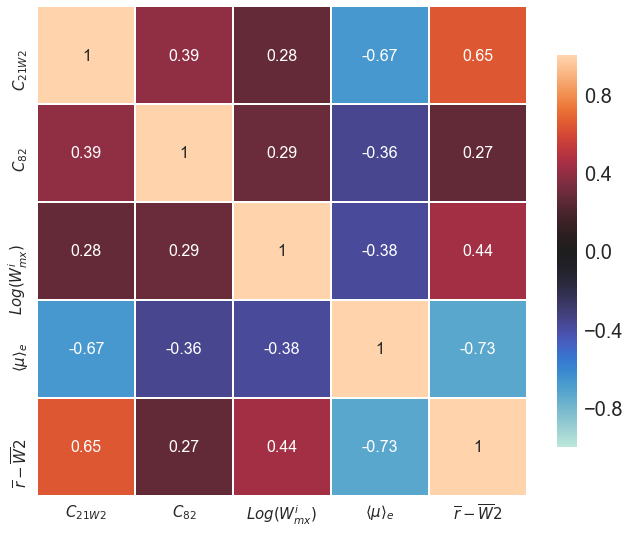

In [82]:
data = {'$'+text1+'$':r_w1, '$Log( W_{mx}^i)$':logWimx, '$C_{21W2}$':c21w, r'$\langle \mu \rangle_e$':mu50, '$C_{82}$':C82}
d = pd.DataFrame.from_dict(data)
### Compute the correlation matrix
corr = d.corr()

### Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

### Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

### Generate a custom diverging colormap
#cmap = sns.diverging_palette(110, 20, as_cmap=False)

sns.set(font_scale=2.0)

### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 16}, annot=True) #, mask=mask)

